<a href="https://colab.research.google.com/github/notabelardoriojas/Painting-Classification-Vision-Transformers/blob/main/Painting_Classification_Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow_addons
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.1 MB/s 
Mounted at /content/drive


In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

In [3]:
import pandas as pd
path_train = '/content/drive/MyDrive/art/training_set/'

'''
target_size = (256,256)
img = load_img(path+file, target_size=target_size)
img_array = img_to_array(img)
'''

train_df = []
classes = 'drawings engraving iconography painting sculpture'.split()

for f, folder in enumerate(sorted(os.listdir(path_train))):
  for file in os.listdir(os.path.join(path_train, folder)):
    row = [f, folder, path_train+f'{folder}/'+file]
    train_df.append(row)
train_df = pd.DataFrame(data=train_df, columns = 'target class filename'.split())

path_test = '/content/drive/MyDrive/art/validation_set/'
test_df = []
for f, folder in enumerate(sorted(os.listdir(path_test))):
  for file in os.listdir(os.path.join(path_test, folder)):
    row = [f, folder, path_test+f'{folder}/'+file]
    test_df.append(row)
test_df = pd.DataFrame(data=test_df, columns = 'target class filename'.split())
train_df


,target,class,filename
0,0,drawings,/content/drive/MyDrive/art/training_set/drawin...
1,0,drawings,/content/drive/MyDrive/art/training_set/drawin...
2,0,drawings,/content/drive/MyDrive/art/training_set/drawin...
3,0,drawings,/content/drive/MyDrive/art/training_set/drawin...
4,0,drawings,/content/drive/MyDrive/art/training_set/drawin...
...,...,...,...
7824,4,sculpture,/content/drive/MyDrive/art/training_set/sculpt...
7825,4,sculpture,/content/drive/MyDrive/art/training_set/sculpt...
7826,4,sculpture,/content/drive/MyDrive/art/training_set/sculpt...
7827,4,sculpture,/content/drive/MyDrive/art/training_set/sculpt...


In [4]:
from sklearn.utils import class_weight 
labels = np.array(train_df.target)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels) 
class_weights
class_weights = {i : class_weights[i] for i in range(5)}

In [5]:
from tqdm import tqdm
target_size = (256,256)
train_x = []
train_y = []
for i in tqdm(train_df.index):
  file = train_df['filename'][i]
  target = np.array(int(train_df['target'][i]))
  try:
    img = load_img(file, target_size=target_size)
  except Exception as e:
    continue
  img_array = img_to_array(img)
  train_x.append(img_array)
  train_y.append(target)
train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = []
test_y = []
for i in tqdm(test_df.index):
  file = test_df['filename'][i]
  target = np.array(int(test_df['target'][i]))
  try:
    img = load_img(file, target_size=target_size)
  except Exception as e:
    continue
  img_array = img_to_array(img)
  test_x.append(img_array)
  test_y.append(target)
test_x = np.array(test_x)
test_y = np.array(test_y)  

 93%|█████████▎| 7311/7829 [1:01:34<05:45,  1.50it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 866/866 [10:37<00:00,  1.36it/s]


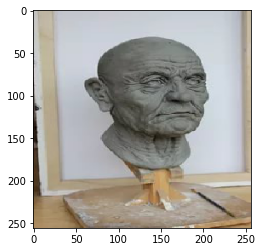

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img_array.astype("uint8"))

In [7]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 256
PATCH_SIZE = 32
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 16
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        #layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_x)

In [9]:

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


VANILLA PATCHES


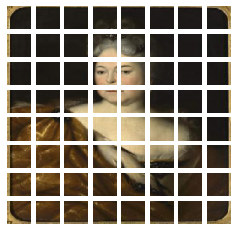

SHIFTED PATCHES
ORIGINAL


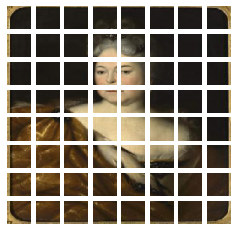

LEFT-UP


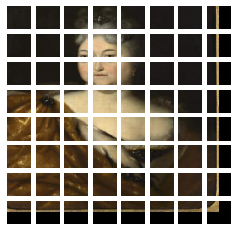

LEFT-DOWN


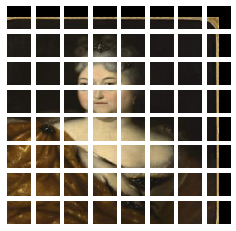

RIGHT-UP


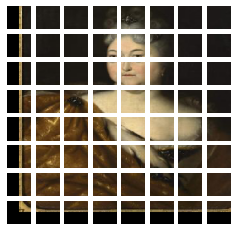

RIGHT-DOWN


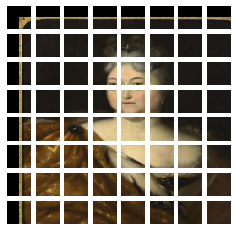

In [10]:
# Get a random image from the training dataset
# and resize the image
image = train_x[np.random.choice(range(train_x.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
print('VANILLA PATCHES')
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()
print('SHIFTED PATCHES')
# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [11]:

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [12]:

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [13]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [14]:
INPUT_SHAPE = (256, 256, 3)
NUM_CLASSES = 5
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [15]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(train_x) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


# Run experiments with the vanilla ViT
#vit = create_vit_classifier(vanilla=True)
#history = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
28/28 [==============================] - 42s 766ms/step - loss: 2.0035 - accuracy: 0.5415 - val_loss: 1.3204 - val_accuracy: 0.4134
Epoch 2/50
28/28 [==============================] - 19s 675ms/step - loss: 0.9436 - accuracy: 0.6506 - val_loss: 1.4109 - val_accuracy: 0.4238
Epoch 3/50
28/28 [==============================] - 19s 676ms/step - loss: 0.8750 - accuracy: 0.6789 - val_loss: 1.3094 - val_accuracy: 0.4677
Epoch 4/50
28/28 [==============================] - 19s 681ms/step - loss: 0.8153 - accuracy: 0.7016 - val_loss: 1.2526 - val_accuracy: 0.5065
Epoch 5/50
28/28 [==============================] - 19s 683ms/step - loss: 0.7845 - accuracy: 0.7096 - val_loss: 1.3396 - val_accuracy: 0.5362
Epoch 6/50
28/28 [==============================] - 19s 690ms/step - loss: 0.7669 - accuracy: 0.7193 - val_loss: 1.3660 - val_accuracy: 0.4729
Epoch 7/50
28/28 [==============================] - 19s 685ms/step - loss: 0.7084 - accuracy: 0.7380 - val_loss: 1.2953 - val_accuracy: 0.5000

In [16]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
